# Imports and Setup

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchaudio

# add parent directory to path to access src/ and database/
sys.path.append(os.path.abspath(''))

# set plot style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded")

Libraries loaded.


# Load Dataframe

In [3]:
# path to the processed dataframe
base_dir = os.getcwd()
data_path = os.path.join(base_dir, '', 'data', 'processed_audio_df.pkl')

# fallback if running from root
if not os.path.exists(data_path):
    data_path = os.path.join(base_dir, 'data', 'processed_audio_df.pkl')

if os.path.exists(data_path):
    df = pd.read_pickle(data_path)
    print(f"Loaded {len(df)} songs from pickle")
else:
    print(f"Error: Could not find {data_path}")

Loaded 500 songs from pickle.


# Visualize Spectrograms

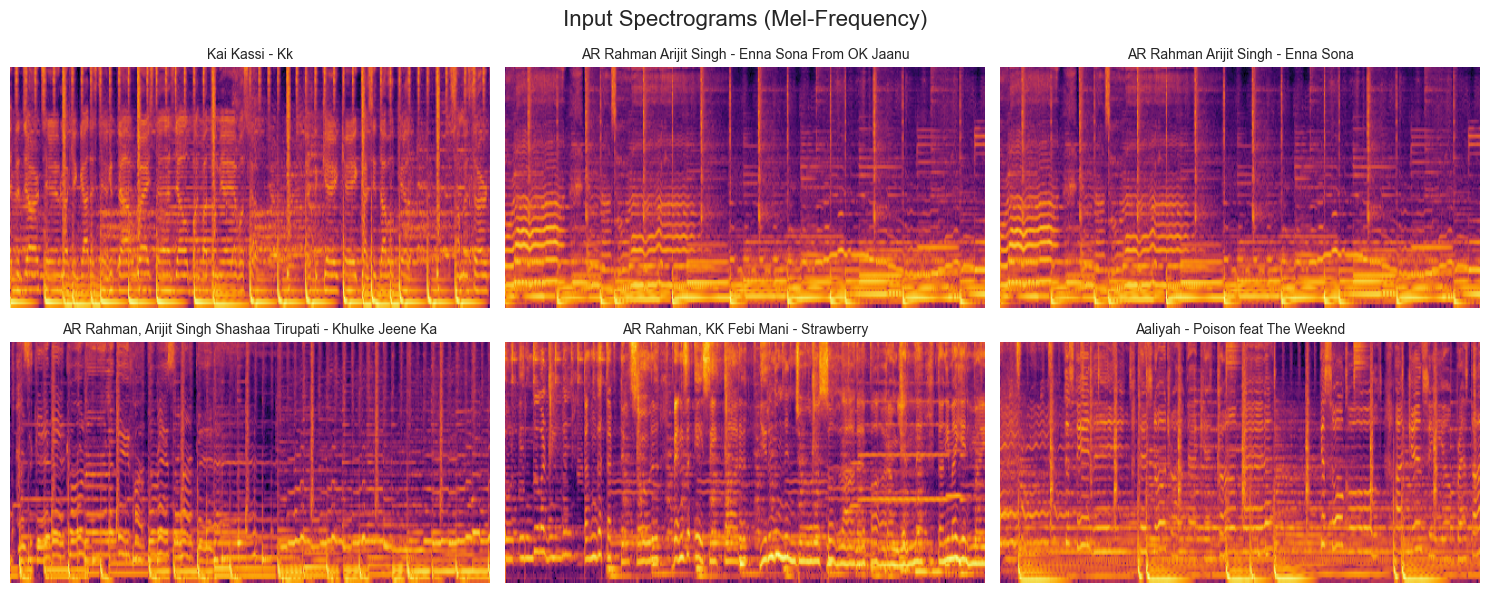

In [4]:
import math

# visualize the first few spectrograms
num_songs = min(6, len(df))
cols = 3
rows = math.ceil(num_songs / cols)

fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(15, rows*3))
ax_flat = ax.flatten()
plt.suptitle('Input Spectrograms (Mel-Frequency)', fontsize=16)

for i in range(num_songs):
    # get spectrogram data
    spec = df.iloc[i]['audio_data']
    name = df.iloc[i]['file_name']

    # plot
    im = ax_flat[i].imshow(spec, origin='lower', aspect='auto', cmap='inferno')
    ax_flat[i].set_title(name, fontsize=10)
    ax_flat[i].axis('off')

plt.tight_layout()
plt.show()

# Feature Extraction Visualization

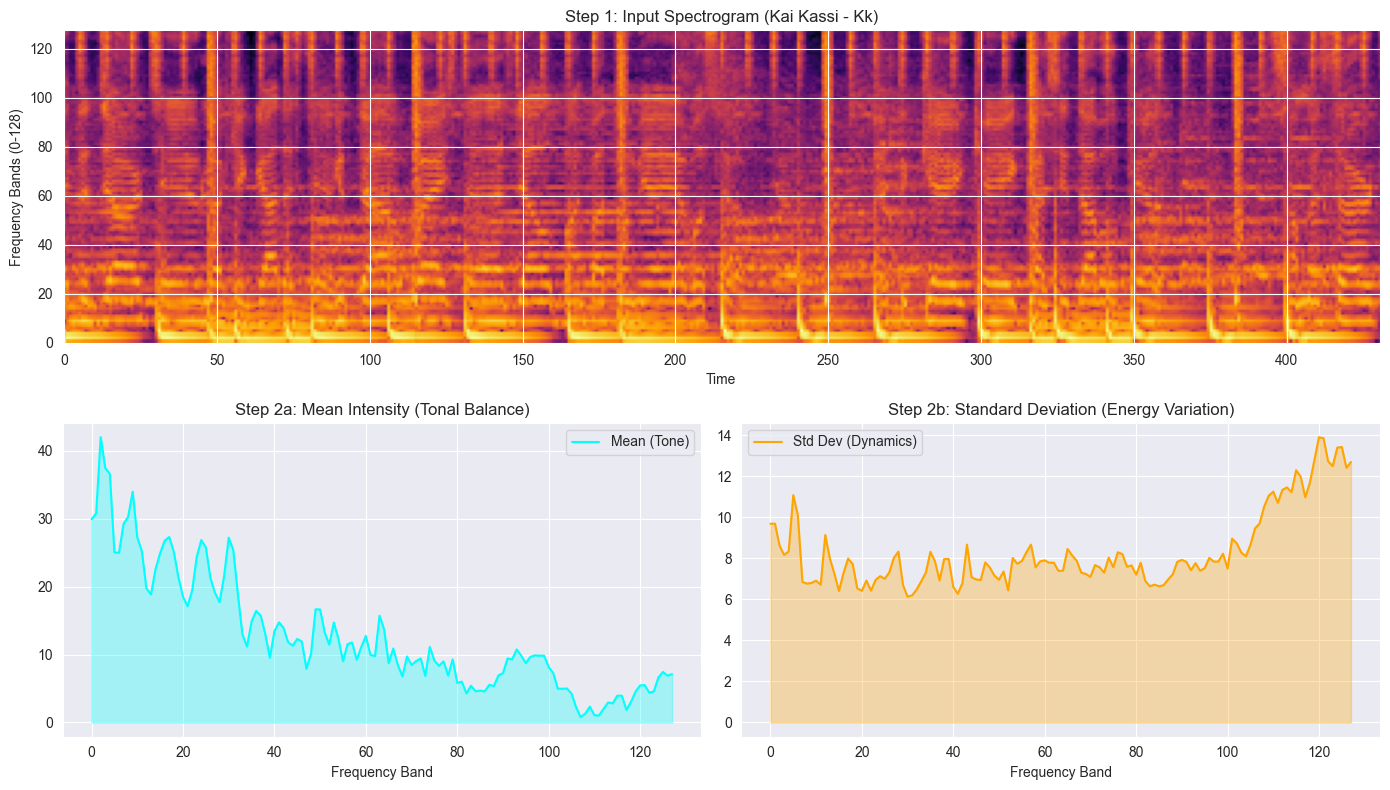

Final Vector Shape: (256,) (128 Mean + 128 Std)


In [5]:
def extract_statistical_features(spectrogram):
    """
    Replicates the logic from extract_features.py
    Input: Spectrogram [128, Time]
    Output: Vector [256]
    """
    # convert to tensor
    spec_tensor = torch.tensor(spectrogram, dtype=torch.float32)

    # mean (tonal balance)
    mean_features = torch.mean(spec_tensor, dim=1)

    # std dev (dynamics)
    std_features = torch.std(spec_tensor, dim=1)

    # combine
    combined = torch.cat((mean_features, std_features))
    return combined.numpy(), mean_features.numpy(), std_features.numpy()

# pick a random song
sample_idx = 0
sample_spec = df.iloc[sample_idx]['audio_data']
sample_name = df.iloc[sample_idx]['file_name']

# calculate vector
full_vector, mean_part, std_part = extract_statistical_features(sample_spec)

# plotting
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2)

# input spectrogram
ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(sample_spec, origin='lower', aspect='auto', cmap='inferno')
ax1.set_title(f"Step 1: Input Spectrogram ({sample_name})")
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency Bands (0-128)")

# extracted features (mean & std)
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(mean_part, color='cyan', label='Mean (Tone)')
ax2.fill_between(range(len(mean_part)), mean_part, alpha=0.3, color='cyan')
ax2.set_title("Step 2a: Mean Intensity (Tonal Balance)")
ax2.set_xlabel("Frequency Band")
ax2.legend()

ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(std_part, color='orange', label='Std Dev (Dynamics)')
ax3.fill_between(range(len(std_part)), std_part, alpha=0.3, color='orange')
ax3.set_title("Step 2b: Standard Deviation (Energy Variation)")
ax3.set_xlabel("Frequency Band")
ax3.legend()

plt.tight_layout()
plt.show()

print(f"Final Vector Shape: {full_vector.shape} (128 Mean + 128 Std)")

# Latent Space Analysis (t-SNE)

Loading vectors from database...
Loaded 500 songs.


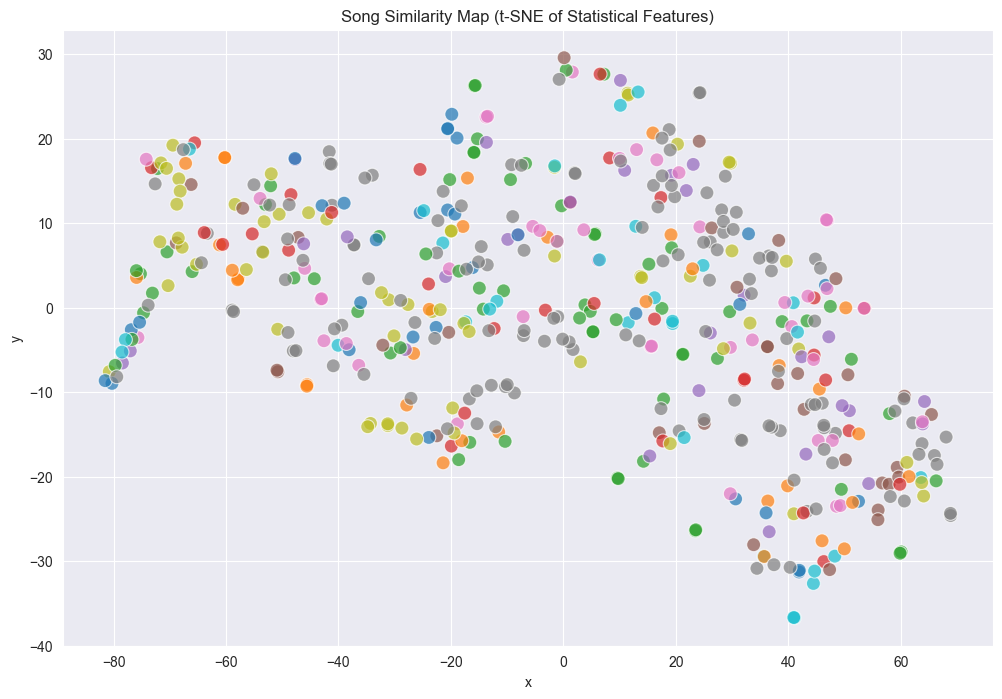

In [11]:
from sklearn.manifold import TSNE
from database.db_connect import load_all_songs

print("Loading vectors from database...")
try:
    song_data_list, latent_matrix = load_all_songs()

    if len(song_data_list) == 0:
        print("Database is empty! Run extract_features.py first.")
    else:
        print(f"Loaded {len(song_data_list)} songs.")

        # run t-SNE
        tsne = TSNE(n_components=2, perplexity=10, random_state=42, init='pca', learning_rate=200)
        X_embedded = tsne.fit_transform(latent_matrix)

        # create plotting dataframe
        plot_df = pd.DataFrame(X_embedded, columns=['x', 'y'])
        plot_df['artist'] = [x['artist'] for x in song_data_list]
        plot_df['song'] = [x['name'] for x in song_data_list]

        # plot
        plt.figure(figsize=(12, 8))

        # use seaborn to color by artist
        sns.scatterplot(
            data=plot_df,
            x='x', y='y',
            hue='artist',
            palette='tab10',
            s=100,
            alpha=0.7,
            legend=False    # disable legend for clarity
        )

        plt.title("Song Similarity Map (t-SNE of Statistical Features)")

        # code for legend
        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

except Exception as e:
    print(f"Database Error: {e}")